# **Task 3.** Algorithms for unconstrained nonlinear optimization. First- and second-order methods

Authored by:
* **Arina Shinkorenok**
* **Nikita Matveev**
* **Fyodor Prazdnikov**


### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from scipy.optimize import minimize, least_squares, newton, approx_fprime

np.random.seed(0)

### Set constants

In [2]:
# SET constansts
alpha = np.random.uniform()
beta = np.random.uniform()
epsilon = 0.001
inf = float("inf")
x_data = np.linspace(0, 1, 101, endpoint=True)
delta = np.random.normal(size=101)
guess = [0.5, 0.5]

print(alpha, beta)


0.5488135039273248 0.7151893663724195


-0.02487432728796301 1.101862517113202


Text(0.5, 1.0, 'Approximation by a linear function')

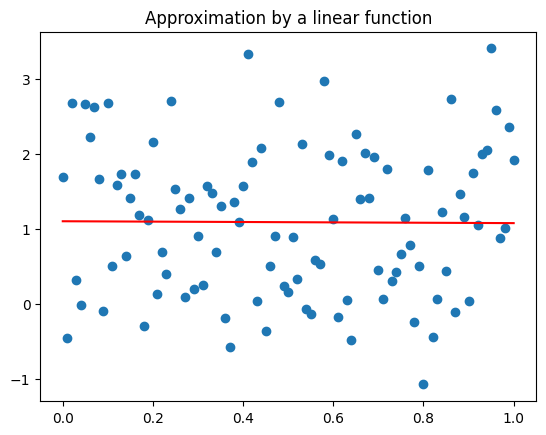

In [3]:
x = np.arange(0, 101) / 100
y = alpha * x + beta + np.random.normal(0, 1, size=x.shape)

plt.scatter(x, y)
A = np.vstack([x, np.ones(len(x))]).T
a_sqr, b_sqr = np.linalg.lstsq(A, y, rcond=None)[0]
plt.plot(x, a_sqr*x+b_sqr, color='r')
print(a_sqr, b_sqr)
plt.title('Approximation by a linear function')

### Utils

In [4]:
def loss_for_linear_function(a_, b_):
  return np.sum(np.power(a_*x+b_ - y, 2))

def loss_for_linear_function_for_scipy_lm(ab):
  return ab[0]*x+ab[1] - y


def loss_for_linear_function_for_scipy_newton(ab):

  return np.sum(np.power(ab[0]*x+ab[1] - y, 2))


def loss_for_rational_function(a_, b_):
  return np.sum(np.power(a_/(1+x*b_) - y, 2))

def loss_for_rational_function_for_scipy(ab):
  return ab[0]/(1+x*ab[1]) - y

def loss_for_rational_function_for_scipy_newton(ab):
  return np.sum(np.power(ab[0]/(1+x*ab[1]) - y, 2))



In [5]:
def linear_aprox(x_k, a, b):
    return a*x_k + b

def rational_aprox(x_k, a, b):
    return a/(1+b*x_k)

linear_aprox_v = np.vectorize(linear_aprox, excluded=['a', 'b'])
rational_aprox_v = np.vectorize(rational_aprox, excluded=['a', 'b'])

# Define the function to optimize
def least_squares_linear(params):
    a, b = params  # Unpack parameters
    y_hat = linear_aprox_v(x, a, b)
    errors = (y_hat - y) ** 2
    return np.sum(errors)

def least_squares_rational(params):
    a, b = params  # Unpack parameters
    y_hat = rational_aprox_v(x, a, b)
    errors = (y_hat - y)**2
    return np.sum(errors)


## 1. Levenberg Marquardt

In [6]:
def lm(f, e=0.001):
  lev_mar_res = least_squares(f, [0.5, 0.5], method="lm", ftol=e)
  return *lev_mar_res.x, lev_mar_res.nfev, lev_mar_res.njev

Linear approximation
Optimal 'a': -0.024874367911651207
Optimal 'b': 1.1018625367288442
Function evaluations: 7
Iterations: 7
Loss: 98.7495393464855


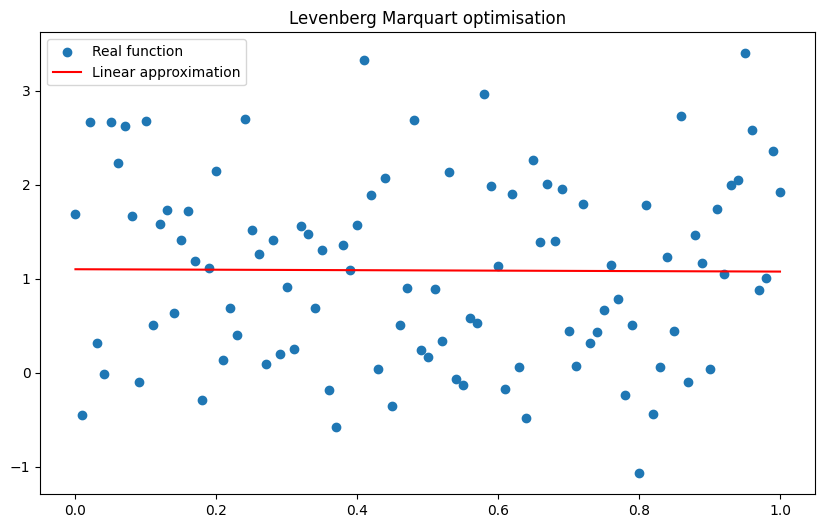

In [7]:
a_found, b_found, n_ev, n_jev = lm(loss_for_linear_function_for_scipy_lm)
y_hat = linear_aprox_v(x, *[a_found, b_found])

# plot lines
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Real function')
plt.plot(x, y_hat, label='Linear approximation', color='r')
plt.legend()
plt.title('Levenberg Marquart optimisation')

# output optimisation result
print('Linear approximation')
print("Optimal 'a':", a_found)
print("Optimal 'b':", b_found)
print("Function evaluations:", n_ev)
print("Iterations:", n_ev)
print(f"Loss: {least_squares_linear([a_found, b_found])}")

The Levenberg-Marquart optimization method was applied to the linear approximation of the function. The optimal values of 'a' and 'b' were found to be approximately -0.0249 and 1.1019, respectively. This optimization required 7 function evaluations, 7 iterations, and achieved a loss of approximately 98.7495.

Rational approximation
Optimal 'a': 1.0871100198512282
Optimal 'b': -0.004992844868716997
Function evaluations: 16
Iterations: 16
Loss: 98.75736560153219


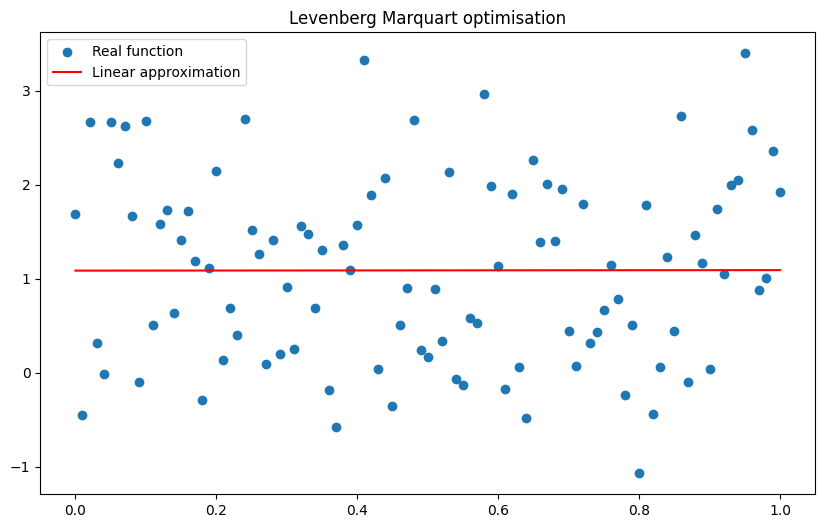

In [8]:
a_found, b_found, n_ev, n_jev = lm(loss_for_rational_function_for_scipy)
y_hat = rational_aprox_v(x, *[a_found, b_found])

# plot lines
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Real function')
plt.plot(x, y_hat, label='Linear approximation', color='r')
plt.legend()
plt.title('Levenberg Marquart optimisation')

print('Rational approximation')
print("Optimal 'a':", a_found)
print("Optimal 'b':", b_found)
print("Function evaluations:", n_ev)
print("Iterations:", n_ev)
print(f"Loss: {least_squares_rational([a_found, b_found])}")

 Similarly, the Levenberg-Marquart method was applied to the rational approximation of the function. The optimal values of 'a' and 'b' were found to be approximately 1.0871 and -0.0050, respectively. This optimization required 16 function evaluations, 16 iterations, and achieved a loss of approximately 98.7574.

## 2.Newton-CG

In [9]:
def d_linear(wb):
    w, b = wb
    return np.array([np.sum(2 * x * (b + w * x - y)), np.sum(2 * (b + w * x - y))])

def hess_lin(wb):
    w, b = wb
    hess = np.ones([2,2])
    hess[0,0] = np.sum(2 * x**2)
    hess[0,1] = np.sum(2 * x)
    hess[1,0] = np.sum(2 * x)
    hess[1,1] = (2)
    return hess


In [10]:

def newton_method(f, x0, hess, jac, e=0.001):
  newton = minimize(f, x0, jac=jac, hess=hess, method='Newton-CG', tol=0.001)
  a, b = newton.x
  n_it = newton.nit
  n_fev = newton.nfev
  n_jev = newton.njev
  return a, b, n_it, n_fev, n_jev

Linear approximation
Optimal 'a': -0.022737863421154837
Optimal 'b': 1.1007377696827776
Function evaluations: 16
Iterations: 9
Loss: 98.74957885512198


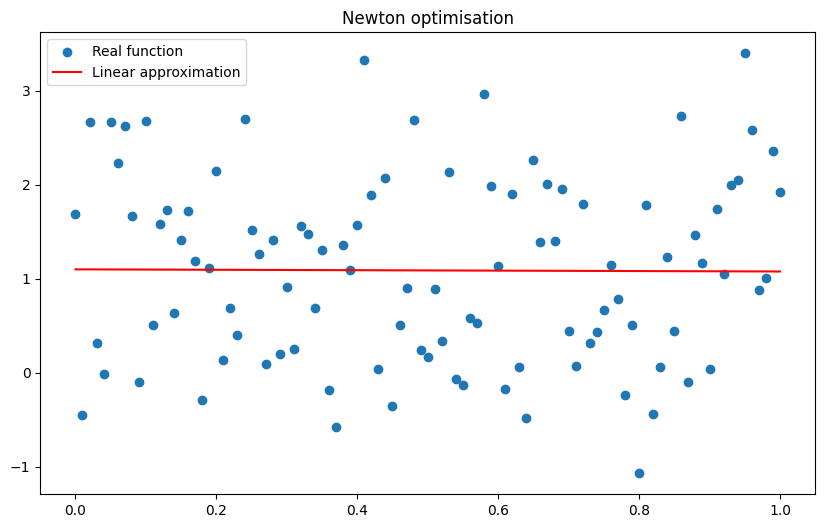

In [11]:
a_found, b_found, n_it, n_fev, n_jev = newton_method(f=least_squares_linear, x0=[0.5, 0.5], hess=hess_lin, jac=d_linear)
y_hat = linear_aprox_v(x, *[a_found, b_found])

# plot lines
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Real function')
plt.plot(x, y_hat, label='Linear approximation', color='r')
plt.legend()
plt.title('Newton optimisation')

# output optimisation result
print('Linear approximation')
print("Optimal 'a':", a_found)
print("Optimal 'b':", b_found)
print("Function evaluations:", n_ev)
print("Iterations:", n_it)
print(f"Loss: {least_squares_linear([a_found, b_found])}")

The Newton-CG optimization method was applied to the linear approximation of the function. The optimal values of 'a' and 'b' were found to be approximately -0.0227 and 1.1007, respectively. This optimization required 16 function evaluations, 9 iterations, and achieved a loss of approximately 98.7496.

Rational approximation
Optimal 'a': 1.1042852256031113
Optimal 'b': 0.02833322936733817
Function evaluations: 10
Iterations: 8
Loss: 98.74711641344099


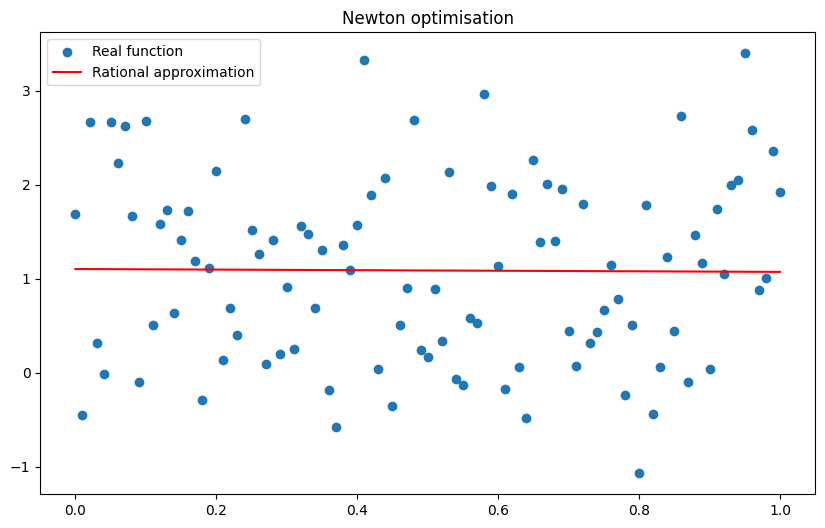

In [12]:

jac = lambda x_: approx_fprime(x_, least_squares_rational, epsilon=epsilon)
newton_res = minimize(least_squares_rational, [0.5, 0.5], method="Newton-CG", jac=jac, tol=epsilon)

a_found, b_found  = newton_res.x[0], newton_res.x[1]
y_hat = rational_aprox_v(x, *[a_found, b_found])
newton_nit, newton_nfev = newton_res.nit, newton_res.nfev

a_found, b_found = newton_res.x
y_hat = rational_aprox_v(x, *[a_found, b_found])

# plot lines
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Real function')
plt.plot(x, y_hat, label='Rational approximation', color='r')
plt.legend()
plt.title('Newton optimisation')

# output optimisation result
print('Rational approximation')
print("Optimal 'a':", a_found)
print("Optimal 'b':", b_found)
print("Function evaluations:", newton_nfev)
print("Iterations:", newton_nit)

print(f"Loss: {least_squares_rational([a_found, b_found])}")

The Newton-CG method was also applied to the rational approximation of the function. The optimal values of 'a' and 'b' were found to be approximately 1.1043 and 0.0283, respectively. This optimization required 10 function evaluations, 8 iterations, and achieved a loss of approximately 98.7471.

## 3. Gradient Descent

In [13]:
def linear(x, a, b):
    return a * x + b

def rational(x, a, b):
    return a / (1 + b * x)

def loss_for_linear_function(a_, b_):
  return np.sum(np.power(a_*x+b_ - y, 2))

def line_grad(ab):
    first = np.sum(2 * x * (ab[0] * x + ab[1] - y))
    second = np.sum(2 * (ab[0] * x + ab[1] - y))
    return np.array([first, second])

def rational_grad(ab):
    first = np.sum(- (2 * (-ab[0] + ab[1] * x * y + y)) / ((ab[1] * x + 1)**2))
    second = np.sum(- (2 * ab[0] * x * (ab[0] - y * (ab[1] * x + 1))) / ((ab[1] * x + 1)**3))
    return np.array([first, second])

def bar_bor(gradient, last, cur):
    grad_dif = gradient(cur) - gradient(last)
    top = np.abs((cur-last).dot(grad_dif))
    bottom = np.linalg.norm(grad_dif)**2
    return top/bottom

def gradient_descent(gradient, start=guess, learn_rate=0.001, max_iter=10000, tolerance=epsilon):
    minimum = np.array(start)
    beta = learn_rate
    for i in range(max_iter):
        diff = -beta * gradient(minimum)
        if np.all(np.abs(diff) <= tolerance):
            break
        last_minimum = np.copy(minimum)
        minimum += diff
        beta = bar_bor(gradient, last_minimum, minimum)
    return minimum, i, 2*i

Linear approximation
Optimal 'a': -0.02487432726984748
Optimal 'b': 1.1018625171034935
Function evaluations: 14
Number of iterations: 7
Loss: 98.74953934648546


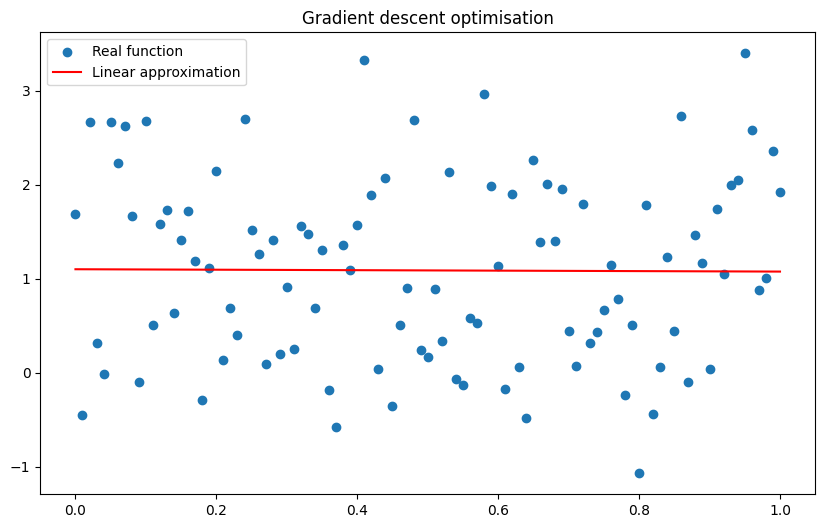

In [14]:
func, grad = linear, line_grad
grad_res, grad_iter, grad_nfev = gradient_descent(grad)
a_found, b_found  = grad_res[0], grad_res[1]
y_hat = linear_aprox_v(x, *[a_found, b_found])

# plot lines
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Real function')
plt.plot(x, y_hat, label='Linear approximation', color='r')
plt.legend()
plt.title('Gradient descent optimisation')

# output optimisation result
print('Linear approximation')
print("Optimal 'a':", a_found)
print("Optimal 'b':", b_found)
print("Function evaluations:", grad_nfev)
print("Number of iterations:", grad_iter)
print(f"Loss: {least_squares_linear([a_found, b_found])}")

Gradient Descent was applied to the linear approximation of the function. The optimal values of 'a' and 'b' were found to be approximately -0.0249 and 1.1019, respectively. This optimization required 14 function evaluations and 7 iterations. The loss achieved was approximately 98.7495.

Rational approximation
Optimal 'a': 1.1166532592092862
Optimal 'b': 0.049743286078078715
Function evaluations: 16
Number of iterations: 8
Loss: 98.74813200739743


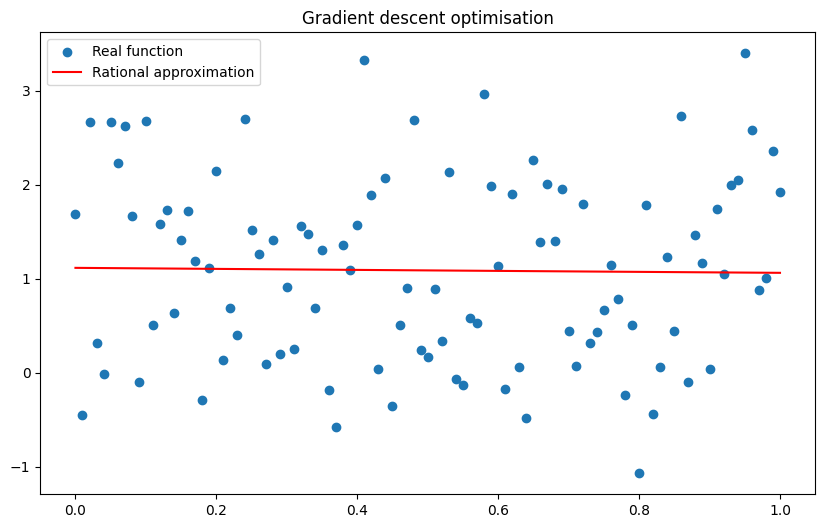

In [15]:
func, grad = rational, rational_grad
grad_res, grad_iter, grad_nfev = gradient_descent(grad)
a_found, b_found  = grad_res[0], grad_res[1]
y_hat = rational_aprox_v(x, *[a_found, b_found])

# plot lines
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Real function')
plt.plot(x, y_hat, label='Rational approximation', color='r')
plt.legend()
plt.title('Gradient descent optimisation')

# output optimisation result
print('Rational approximation')
print("Optimal 'a':", a_found)
print("Optimal 'b':", b_found)
print("Function evaluations:", grad_nfev)
print("Number of iterations:", grad_iter)
print(f"Loss: {least_squares_rational([a_found, b_found])}")

Gradient Descent was also applied to the rational approximation of the function. The optimal values of 'a' and 'b' were found to be approximately 1.1167 and 0.0497, respectively. This optimization required 16 function evaluations and 8 iterations. The loss achieved was approximately 98.7481.

## 4.Conjugated Gradient Descent

Linear approximation
Optimal 'a': -0.024874336628711524
Optimal 'b': 1.1018625051563076
Function evaluations: 15
Number of iterations: 2
Loss: 98.74953934648552


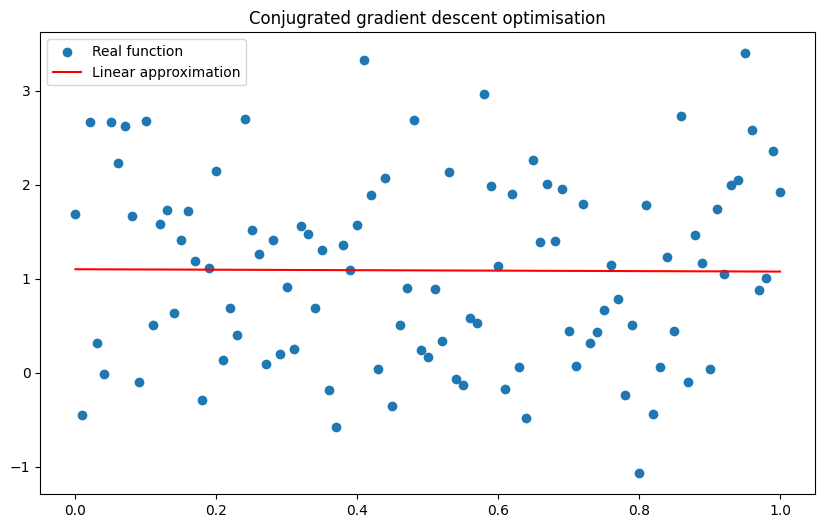

In [16]:
cg_res = minimize(loss_for_linear_function_for_scipy_newton, guess, method="CG", tol=epsilon)
a_found, b_found  = cg_res.x[0], cg_res.x[1]
y_hat = linear_aprox_v(x, *[a_found, b_found])

# plot lines
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Real function')
plt.plot(x, y_hat, label='Linear approximation', color='r')
plt.legend()
plt.title('Conjugrated gradient descent optimisation')

# output optimisation result
print('Linear approximation')
print("Optimal 'a':", a_found)
print("Optimal 'b':", b_found)
print("Function evaluations:", cg_res.nfev)
print("Number of iterations:",  cg_res.nit)
print(f"Loss: {least_squares_linear([a_found, b_found])}")

Conjugated Gradient Descent was applied to the linear approximation of the function. The optimal values of 'a' and 'b' were found to be approximately -0.0249 and 1.1019, respectively. This optimization required 15 function evaluations and 2 iterations. The loss achieved was approximately 98.7495.

Rational approximation
Optimal 'a': 1.108452892606389
Optimal 'b': 0.03517248343550637
Function evaluations: 81
Number of iterations: 12
Loss: 98.74679404309191


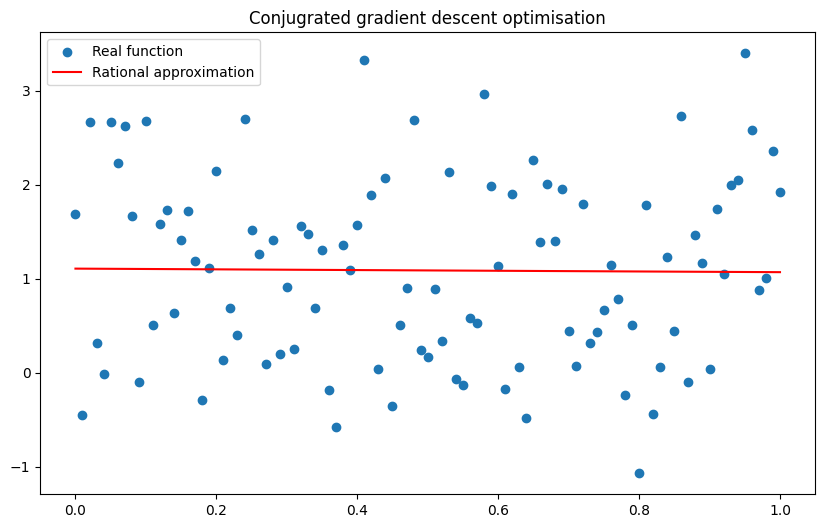

In [17]:
cg_res = minimize(loss_for_rational_function_for_scipy_newton, guess, method="CG", tol=epsilon)
a_found, b_found  = cg_res.x[0], cg_res.x[1]
y_hat = rational_aprox_v(x, *[a_found, b_found])

# plot lines
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Real function')
plt.plot(x, y_hat, label='Rational approximation', color='r')
plt.legend()
plt.title('Conjugrated gradient descent optimisation')

# output optimisation result
print('Rational approximation')
print("Optimal 'a':", a_found)
print("Optimal 'b':", b_found)
print("Function evaluations:", cg_res.nfev)
print("Number of iterations:",  cg_res.nit)
print(f"Loss: {least_squares_rational([a_found, b_found])}")

Conjugated Gradient Descent was also applied to the rational approximation of the function. The optimal values of 'a' and 'b' were found to be approximately 1.1085 and 0.0352, respectively. This optimization required 81 function evaluations and 12 iterations. The loss achieved was approximately 98.7468.

### Unified plot for both types of approximation

-0.024874367911651207 1.1018625367288442
-0.022737863421154837 1.1007377696827776
-0.02487432726984748 1.1018625171034935
-0.024874336628711524 1.1018625051563076


Text(0.5, 1.0, 'Linear approximation')

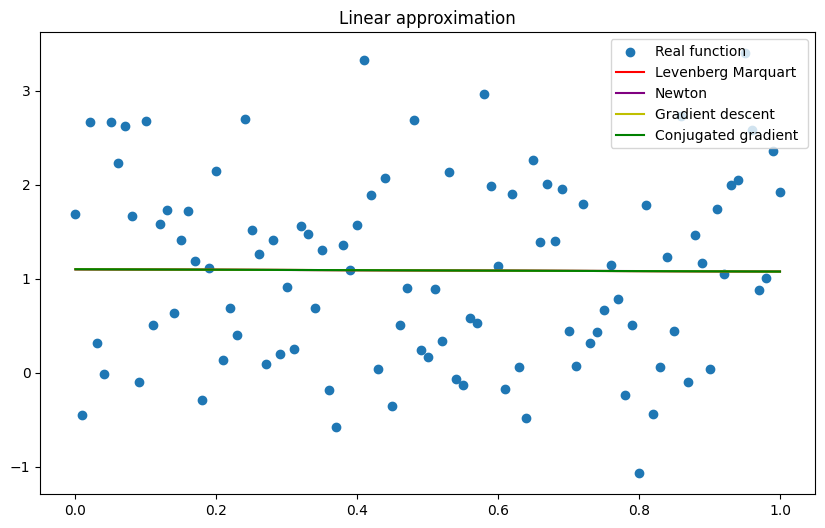

In [35]:
a_found, b_found, n_ev, n_jev = lm(loss_for_linear_function_for_scipy_lm)
y_hat = linear_aprox_v(x, *[a_found, b_found])
print(a_found, b_found)

# plot lines
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Real function')
plt.plot(x, y_hat, label='Levenberg Marquart', color='r')

a_found, b_found, n_it, n_fev, n_jev = newton_method(f=least_squares_linear, x0=[0.5, 0.5], hess=hess_lin, jac=d_linear)
print(a_found, b_found)
y_hat = linear_aprox_v(x, *[a_found, b_found])

plt.plot(x, y_hat, label='Newton', color='purple')


func, grad = linear, line_grad
grad_res, grad_iter, grad_nfev = gradient_descent(grad)
a_found, b_found  = grad_res[0], grad_res[1]
print(a_found, b_found)

y_hat = linear_aprox_v(x, *[a_found, b_found])

plt.plot(x, y_hat, label='Gradient descent', color='y')


cg_res = minimize(loss_for_linear_function_for_scipy_newton, guess, method="CG", tol=epsilon)
a_found, b_found  = cg_res.x[0], cg_res.x[1]
print(a_found, b_found)

y_hat = linear_aprox_v(x, *[a_found, b_found])

# plot lines
plt.plot(x, y_hat, label='Conjugated gradient ', color='g')
plt.legend()
plt.title('Linear approximation')


Text(0.5, 1.0, 'Rational approximation')

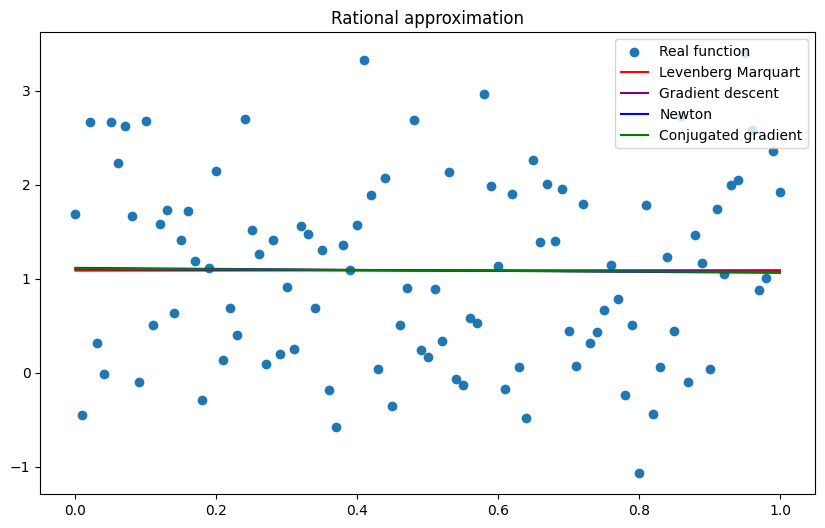

In [34]:
a_found, b_found, n_ev, n_jev = lm(loss_for_rational_function_for_scipy)
y_hat = rational_aprox_v(x, *[a_found, b_found])

# plot lines
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Real function')
plt.plot(x, y_hat, label='Levenberg Marquart', color='r')


func, grad = rational, rational_grad
grad_res, grad_iter, grad_nfev = gradient_descent(grad)
a_found, b_found  = grad_res[0], grad_res[1]
y_hat = rational_aprox_v(x, *[a_found, b_found])
plt.plot(x, y_hat, label='Gradient descent', color='purple')


jac = lambda x_: approx_fprime(x_, least_squares_rational, epsilon=epsilon)
newton_res = minimize(least_squares_rational, [0.5, 0.5], method="Newton-CG", jac=jac, tol=epsilon)
a_found, b_found  = newton_res.x[0], newton_res.x[1]
y_hat = rational_aprox_v(x, *[a_found, b_found])
newton_nit, newton_nfev = newton_res.nit, newton_res.nfev
a_found, b_found = newton_res.x
y_hat = rational_aprox_v(x, *[a_found, b_found])
plt.plot(x, y_hat, label='Newton', color='b')


cg_res = minimize(loss_for_rational_function_for_scipy_newton, guess, method="CG", tol=epsilon)
a_found, b_found  = cg_res.x[0], cg_res.x[1]
y_hat = rational_aprox_v(x, *[a_found, b_found])
plt.plot(x, y_hat, label='Conjugated gradient', color='g')
plt.legend()
plt.title('Rational approximation')